Feature importance plotted


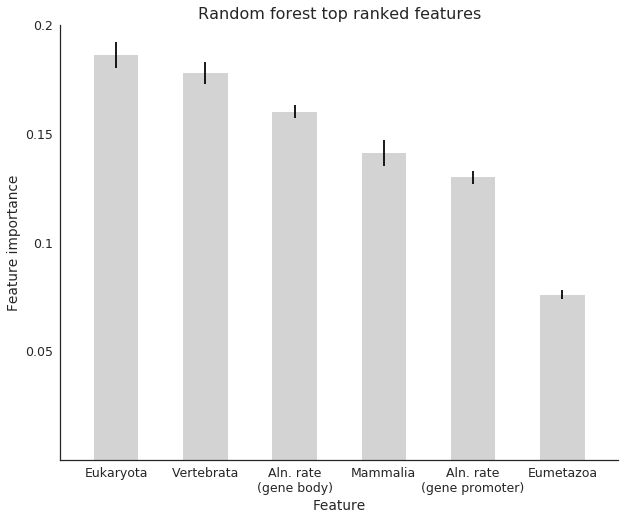

In [12]:
%matplotlib inline

import os as os
import numpy as np
import numpy.random as rng
import json as js
import csv as csv
import pickle as pck
import collections as col
import operator as op
import functools as fnt
import warnings as warn
import itertools as itt

import sklearn.exceptions as skle

warn.filterwarnings('error', message='Precision.+', category=skle.UndefinedMetricWarning)

import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from scipy.stats import mannwhitneyu as mwu
from scipy.stats import ttest_1samp as tt

from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier

date = '20180316'

sns.set(style='white',
        font_scale=1.25,
        rc={'font.family': ['sans-serif'],
            'font.sans-serif': ['DejaVu Sans']})

fhgfs_base = '/TL/deep/fhgfs/projects/pebert/thesis'
conf_folder = '/home/pebert/work/code/mpggit/crossspecies/graphics'

plot_labels = js.load(open(os.path.join(conf_folder, 'labels', 'cs_labels.json'), 'r'))
plot_colors = js.load(open(os.path.join(conf_folder, 'colors', 'cs_colors.json'), 'r'))
plot_shapes = js.load(open(os.path.join(conf_folder, 'shapes', 'cs_shapes.json'), 'r'))

cv_file = os.path.join(fhgfs_base,
                       'projects/cross_species/processing/norm/task_geneage_model/training',
                       'rfcls_geneage_train_10x10cv.h5')

run_plot_rfcls_ftimp = True

show_figures = True

out_folder = '/TL/deep-external01/nobackup/pebert/cloudshare/mpiinf/phd/chapter_projects/crossspecies/figures/pub'
save_figures = True

gene_ages = [('Eumetazoa', 948), ('Eukaryota', 2100),
             ('Vertebrata', 615), ('Opisthokonta', 1105),
             ('Mammalia', 177), ('Euk./Bac.', 3500),
             ('Euk./Arch.', 3000), ('Cell. org.', 4200)]

age_labels = {'Eumetazoa': 948, 'Eukaryota': 2100,
              'Vertebrata': 615, 'Opisthokonta': 1105,
              'Mammalia': 177, 'Euk./Bac.': '?',
              'Euk./Arch.': '?', 'Cell. org.': 4200}

group_labels = {'ftage_bin_eumeta': 'Eumetazoa', 'ftage_bin_euk': 'Eukaryota',
                'ftage_bin_vert': 'Vertebrata', 'ftage_bin_opist': 'Opisthokonta',
                'ftage_bin_mamm': 'Mammalia', 'ftage_bin_eukbac': 'Euk./Bac.',
                'ftage_bin_eukarch': 'Euk./Arch.', 'ftage_bin_cellorg': 'Cell. org.',
                'ftcons_pct_body': 'Aln. rate\n(gene body)', 'ftcons_pct_reg5p': 'Aln. rate\n(gene promoter)'}


def plot_rfcls_ftimp():
    
    with pd.HDFStore(cv_file, 'r') as hdf:
        cv_perf = hdf['/data/joint/perf']
        used_feat = [c for c in cv_perf if c.startswith('ft')]
        fig, exart = plot_feat_imp(cv_perf, used_feat)
        if save_figures:
            outfile = '{}_fig_X_supp_rfcls_confid_featimp.svg'.format(date)
            outpath = os.path.join(out_folder, 'supp', outfile)
            fig.savefig(outpath, bbox_extra_artists=exart, bbox_inches='tight')
            outpath = outpath.replace('.svg', '.png')
            fig.savefig(outpath, bbox_extra_artists=exart, bbox_inches='tight', dpi=300)
            outpath = outpath.replace('.png', '.pdf')
            fig.savefig(outpath, bbox_extra_artists=exart, bbox_inches='tight')
    return
        

        

def apply_to_testdata(trainfeat, trainlabels, testdata, features):
    test_human = testdata.loc[test_data['species'] == 'human', :]
    test_mouse = testdata.loc[test_data['species'] == 'mouse', :]

    human_feat = test_human.loc[:, feat_cols]
    human_label = np.array(test_human['target'] >= 0.5, dtype=np.int8)

    mouse_feat = test_mouse.loc[:, feat_cols]
    mouse_label = np.array(test_mouse['target'] >= 0.5, dtype=np.int8)

    # parameters as determined by CV - set manually,
    # do not extract from CV dataframe...
    full_model = RandomForestClassifier(n_estimators=1000, criterion='gini',
                                        min_samples_split=128, n_jobs=4)
    full_model.fit(trainfeat, trainlabels)

    human_prob = full_model.predict_proba(human_feat)
    human_pred = full_model.predict(human_feat)
    mouse_prob = full_model.predict_proba(mouse_feat)
    mouse_pred = full_model.predict(mouse_feat)

    human_pos_prob = np.zeros_like(human_pred, dtype=np.float32)
    human_pos_prob[human_pred == 1] = human_prob[human_pred == 1, 1]
    human_pos_prob[human_pred == 0] = 1 - human_prob[human_pred == 0, 0]

    mouse_pos_prob = np.zeros_like(mouse_pred, dtype=np.float32)
    mouse_pos_prob[mouse_pred == 1] = mouse_prob[mouse_pred == 1, 1]
    mouse_pos_prob[mouse_pred == 0] = 1 - mouse_prob[mouse_pred == 0, 0]

    human_test_perf = np.round(roc_auc_score(human_label, human_pos_prob), 2)
    mouse_test_perf = np.round(roc_auc_score(mouse_label, mouse_pos_prob), 2)
    return human_test_perf, mouse_test_perf


def plot_feat_imp(cv_data, features):
    
    plot_data = cv_data.loc[:, features]
    plot_mean = plot_data.mean(axis=0).round(3)
    plot_mean = plot_mean[plot_mean > 0.05]
    plot_mean.sort_values(ascending=False, inplace=True)
    
    plot_std = plot_data.std(axis=0).round(3)
    plot_std = plot_std[plot_mean.index]
    
    fig, ax = plt.subplots(figsize=(10, 8))
    
    ax.set_ylim(0, 0.2)
    
    bar_width = 0.1
    x_fg = np.arange(0.2, plot_mean.size, 0.2)[:plot_mean.size]
    ax.set_xlim(-0.025, x_fg.max() + 0.025)
    x_ticks = x_fg
    x_ticks -= 0.1
    
    y_ticks = [0.05, 0.1, 0.15, 0.2]
    y_tick_labels = list(map(str, y_ticks))
    
    ax.set_yticks(y_ticks)
    ax.set_yticklabels(y_tick_labels)
    
    x_labels = []
    for feat in plot_mean.index:
        if '_abs_' in feat:
            lut = feat.replace('_abs_', '_bin_')
        else:
            lut = feat
        label = group_labels[lut]
        x_labels.append(label)
    x_ticks = x_ticks[:len(x_labels)]
        
#     ax.bar(x_fg[:plot_mean.size], plot_mean.values,
#            yerr=[np.zeros_like(plot_std), plot_std],
#            color='lightgrey', width=bar_width,
#            label='Feature importance')
    ax.bar(x_fg[:plot_mean.size], plot_mean.values,
           yerr=plot_std,
           color='lightgrey', width=bar_width,
           label='Feature importance')
    
    #ax.legend(fontsize=14)
    
    ax.set_xticks(x_ticks)
    ax.set_xticklabels(x_labels, rotation=0)
    
    ax.set_ylabel('Feature importance')
    ax.set_xlabel('Feature')
    ax.set_title('Random forest top ranked features', fontsize=16)
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    return fig, []
    
    
if run_plot_rfcls_ftimp:
    plot_rfcls_ftimp()
    print('Feature importance plotted')
#     with pd.HDFStore(fpath, 'r') as hdf:
#         train_data = hdf['/data/joint/data']
#         print(train_data.shape)
#         train_scores = train_data.loc[:, ['target']]
#         train_scores.index = train_data['name']
#         train_labels = np.array(train_scores['target'] > 0.5, dtype=np.int8)
#         train_labels = pd.Series(train_labels, index=train_scores.index)
        
#         if assert_null_gene_ages:
#             null_perf = make_null_model(train_labels)
#             null_perf = null_perf.mean()
#         else:
#             null_perf = 0.5
#         train_perf = hdf['/data/joint/perf']
        
#         print('Test scores')
#         print(train_perf['test_score'].mean().round(2))
#         print(train_perf['test_score'].std().round(3))
        
#         feat_cols = [c for c in train_perf.columns if c.startswith('ft')]
#         train_feat = train_data.loc[:, feat_cols]
        
# #         ##
# #         foo = train_feat.copy()
# #         foo.index = train_data['name']
# #         foo['target'] = train_scores
# #         print(foo.corr(method='pearson'))
# #         raise
# #         ##
        
#         test_data = hdf['/data/single/data']
        
#         hsa_perf, mmu_perf = apply_to_testdata(train_feat, train_labels,
#                                                test_data, feat_cols)
#         print(hsa_perf)
#         print(mmu_perf)
